In [4]:
import pickle
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

**PNC:/opt/conda/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  pyproj could not be found, so IO/API coordinates cannot be converted to lat/lon; to fix, install pyproj or basemap (e.g., `pip install pyproj)`


### Some functions

In [15]:
def mag2db(y):
    """Convert magnitude response to decibels for a simple array.

    Args:
        y (numpy array): Power spectrum, raw magnitude response.

    Returns:
        dby (numpy array): Power spectrum in dB

    """
    dby = 20 * np.log10(y)
    return dby

stdPSDFn = lambda x: (x- x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)

### Load data

In [28]:
allRes = {}

datFils = sorted(list(Path("./").glob("*SGM*PSD*.pkl")));datFils
dicNams = ["BaySGM-Uni", "BaySGM-Sep", "OrgSGM"]
for ix, fil in enumerate(datFils):
    with open(fil, "rb") as f:
        print(fil, dicNams[ix])
        allRes[dicNams[ix]] = np.array(pickle.load(f))

SGM_Uni_PSD_db.pkl BaySGM-Uni
SGM_each_PSD_db.pkl BaySGM-Sep
orgSGM_PSD_db.pkl OrgSGM


In [29]:
# MEG PSD
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
freqs = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

allRes["MEG"] = mag2db(np.abs(ind_psd)).mean(axis=0).T

### Analysis

**SBI procedure**


1. Generate many prior samples of the 7 parameters and for each prior sample $v_i$, we can run the SGM model to obtain the modeled spectrum $S_i$.

2. Using the prior samples and the generated modeled spectrum, we can train a neural network $f(v|S)$ which we can feed the MEG spectrum and obtain the posterior density of the parameters $v$.

3. Get the posterior samples from each density.


A uniform connectivity matrix $\rightarrow$ BaySGM-Uni

Using individual connectivity matrix $\rightarrow$ BaySGM-Sep

In [49]:
ltys = [
    "-ok", 
    "-sb", 
    "-hg", 
    "-Hr"
]

ltys1 = [
    "ok", 
    "sb", 
    "hg", 
    "Hr"
]

#### Overall PSD fitness

In [32]:
plotRes = {}
for key, v in allRes.items():
    v1 = v.mean(axis=0)
    stdV = (v1 - v1.mean())/v1.std()
    plotRes[key] = stdV
    

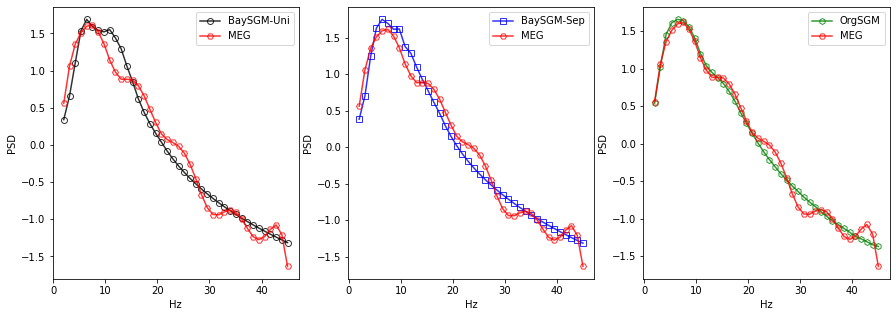

In [59]:
plt.figure(figsize=[15, 5])
for ix, key in enumerate(dicNams):
    v = plotRes[key]
    plt.subplot(131+ix)
    plt.plot(freqs, v,  ltys[ix], label=key, fillstyle = 'none', alpha = 0.8)
    plt.plot(freqs, plotRes["MEG"],  ltys[3], label="MEG", fillstyle = 'none', alpha = 0.8)
    plt.xlabel("Hz")
    plt.ylabel("PSD")
    plt.legend()

#### Pearson correlation for each data

In [45]:
corrDics = {}
for _, key in enumerate(dicNams):
    curSGM = allRes[key]
    MEG = allRes["MEG"]
    corrs = []
    for ix in range(MEG.shape[0]):
        curMEG = MEG[ix, :]
        curMod = curSGM[ix, :]
        corrs.append(ss.pearsonr(curMEG, curMod)[0])
    corrDics[key] = corrs

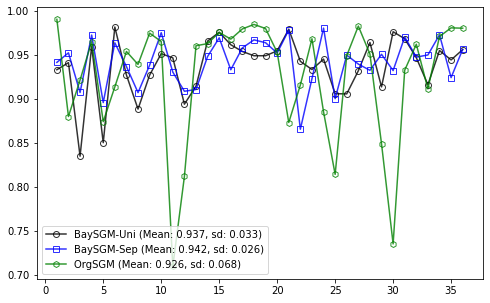

In [58]:
plt.figure(figsize=[8, 5])
for ix, key in enumerate(dicNams):
    v = np.array(corrDics[key])
    plt.plot(np.arange(1, 37), v, ltys[ix], label=f"{key} (Mean: {v.mean():.3f}, sd: {v.std():.3f})", fillstyle = 'none', alpha = 0.8)
plt.legend()

In [ ]:
x